In [3]:
import random

import torch
import matplotlib.pyplot as plt

from src.visualization.utils.plot_utils import (
    get_indices_from_probe_suite,
    get_loss_dataset,
)

In [18]:
df = get_loss_dataset("../models/losses/cifar10-20230320_1038")
df.drop_duplicates(subset=["epoch", "sample_index", "stage"], inplace=True)
df["epoch"] = df["epoch"].astype(int)
max_epoch = df["epoch"].max() + 1


In [19]:
assert df['stage'][df['stage'] == 'val'].count() == max_epoch * 2500
assert df['stage'][df['stage'] == 'train'].count() == max_epoch * 50000

In [20]:
probe_suite = torch.load(f"../data/processed/cifar10/train_probe_suite.pt")

In [21]:
len(probe_suite)

50000

In [6]:
suite_names = {
        "typical": "Typical",
        "atypical": "Atypical",
        "random_outputs": "Random outputs",
        "random_inputs_outputs": "Random inputs and outputs",
        "corrupted": "Corrupted",
}

for suite_attr, suite_name in suite_names.items():
        suite = getattr(probe_suite, suite_attr)
        indices = get_indices_from_probe_suite(suite)
        random.shuffle(indices)
        train_indices = indices[:250]
        val_indices = indices[250:]
        df.loc[df["sample_index"].isin(train_indices), "suite"] = suite_name
        df.loc[df["sample_index"].isin(val_indices), "suite"] = suite_name + " [Val]"

df["suite"] = df["suite"].fillna("Train")

In [7]:
df.head()

,batch_idx,loss,sample_index,y,y_hat,epoch,stage,suite
0,0,2.550781,42007,1,7,0,train,Train
1,0,2.203125,28785,4,7,0,train,Train
2,0,3.164062,23493,2,7,0,train,Train
3,0,2.347656,153,4,7,0,train,Train
4,0,2.832031,474,2,7,0,train,Train


In [8]:
df["prediction"] = df["y"] == df["y_hat"]

val_df = df[df['stage'] == 'val']
train_df = df[df['stage'] == 'train']

val_df

,batch_idx,loss,sample_index,y,y_hat,epoch,stage,suite,prediction
50000,0,2.263672,772,1,4,0,val,Typical,False
50001,0,2.263672,35878,1,4,0,val,Typical,False
50002,0,2.330078,25506,9,4,0,val,Typical [Val],False
50003,0,2.263672,942,1,4,0,val,Typical [Val],False
50004,0,2.265625,16938,1,4,0,val,Typical,False
...,...,...,...,...,...,...,...,...,...
7875251,19,0.193848,24196,5,5,99,val,Corrupted [Val],True
7875252,19,0.026596,11660,9,9,99,val,Corrupted,True
7875253,19,0.520996,26792,2,2,99,val,Corrupted [Val],True
7875254,19,0.470215,35231,9,9,99,val,Corrupted [Val],True


In [135]:
final_val = val_df.groupby(["epoch", "suite"]).agg({"prediction": "mean"})
final_val.reset_index(inplace=True)
final_val["prediction"] = final_val["prediction"] * 100

final_val

,epoch,suite,prediction
0,0,Atypical,8.4
1,0,Atypical [Val],13.2
2,0,Corrupted,9.2
3,0,Corrupted [Val],13.2
4,0,Random inputs and outputs,8.8
...,...,...,...
1495,149,Random inputs and outputs [Val],100.0
1496,149,Random outputs,100.0
1497,149,Random outputs [Val],100.0
1498,149,Typical,100.0


In [136]:
final_train = train_df.groupby(["epoch", "suite"]).agg({"prediction": "mean"})
final_train.reset_index(inplace=True)
final_train["prediction"] = final_train["prediction"] * 100
suites = sorted(final_train["suite"].unique())

In [9]:
# Plot
line_styles = ["solid", "dashed", "dashdot", "dotted"]
marker_list = ["o", "*", "X", "P", "p", "D", "v", "^", "h", "1", "2", "3", "4"]
marker_colors = [
    "tab:gray",
    "tab:green",
    "tab:blue",
    "tab:purple",
    "tab:orange",
    "tab:red",
    "tab:pink",
    "tab:olive",
    "tab:brown",
    "tab:cyan",
]

plot_titles = {
    "cifar10": "CIFAR-10",
    "cifar100": "CIFAR-100",
    "imagenet": "ImageNet",
}

Text(0, 0.5, 'Accuracy (%)')

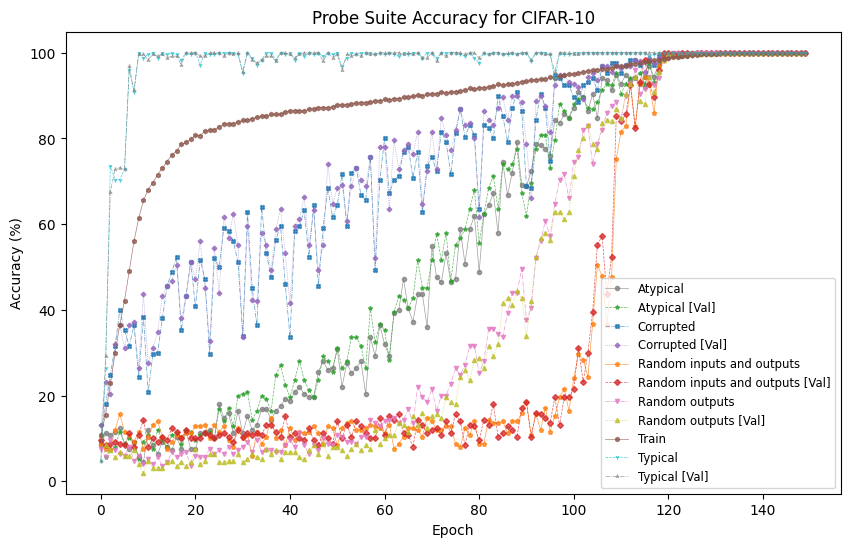

In [138]:
plt.figure(figsize=(10, 6))
plt.title(f"Probe Suite Accuracy for {plot_titles['cifar10']}")
for i, suite in enumerate(suites):
    if "Train" in suite:
        plt.plot(
        final_train[final_train["suite"] == suite]["epoch"],
        final_train[final_train["suite"] == suite]["prediction"],
        label=suite,
        alpha=0.75,
        linewidth=0.5,
        linestyle=line_styles[i % len(line_styles)],
        marker=marker_list[i % len(marker_list)],
        markersize=3,
        color=marker_colors[i % len(marker_colors)],
    )
    else:
        plt.plot(
            final_val[final_val["suite"] == suite]["epoch"],
            final_val[final_val["suite"] == suite]["prediction"],
            label=suite,
            alpha=0.75,
            linewidth=0.5,
            linestyle=line_styles[i % len(line_styles)],
            marker=marker_list[i % len(marker_list)],
            markersize=3,
            color=marker_colors[i % len(marker_colors)],
        )
plt.legend(loc="lower right", fontsize="small")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")

In [10]:
val_df

,batch_idx,loss,sample_index,y,y_hat,epoch,stage,suite,prediction
50000,0,2.263672,772,1,4,0,val,Typical,False
50001,0,2.263672,35878,1,4,0,val,Typical,False
50002,0,2.330078,25506,9,4,0,val,Typical [Val],False
50003,0,2.263672,942,1,4,0,val,Typical [Val],False
50004,0,2.265625,16938,1,4,0,val,Typical,False
...,...,...,...,...,...,...,...,...,...
7875251,19,0.193848,24196,5,5,99,val,Corrupted [Val],True
7875252,19,0.026596,11660,9,9,99,val,Corrupted,True
7875253,19,0.520996,26792,2,2,99,val,Corrupted [Val],True
7875254,19,0.470215,35231,9,9,99,val,Corrupted [Val],True


In [165]:
# compute cumulative number of samples learned pr epoch pr suite
first_learned = {
    "Typical": [],
    "Atypical": [],
    "Random outputs": [],
    "Random inputs and outputs": [],
    "Corrupted": [],
    "Typical [Val]": [],
    "Atypical [Val]": [],
    "Random outputs [Val]": [],
    "Random inputs and outputs [Val]": [],
    "Corrupted [Val]": [],
    "Train": [],
}

learned = {
    "Typical": set([]),
    "Atypical": set([]),
    "Random outputs": set([]),
    "Random inputs and outputs": set([]),
    "Corrupted": set([]),
    "Typical [Val]": set([]),
    "Atypical [Val]": set([]),
    "Random outputs [Val]": set([]),
    "Random inputs and outputs [Val]": set([]),
    "Corrupted [Val]": set([]),
    "Train": set([]),
}

suite_names = ["Typical", "Atypical", "Random outputs", "Random inputs and outputs", "Corrupted", "Typical [Val]", "Atypical [Val]", "Random outputs [Val]", "Random inputs and outputs [Val]", "Corrupted [Val]"]
temp_train = train_df[train_df['suite'] == 'Train']

for epoch in range(max_epoch):
    epoch_train_group = temp_train.groupby(["epoch"]).get_group(epoch)
    learned["Train"].update(epoch_train_group["sample_index"][epoch_train_group['prediction'] == True].values)
    first_learned["Train"].append(len(learned["Train"]) / 47500)
    epoch_val_group = val_df.groupby(["epoch"]).get_group(epoch)
    for suite in suite_names:
        suite_group = epoch_val_group.groupby(["suite"]).get_group(suite)
        learned[suite].update(suite_group["sample_index"][suite_group['prediction'] == True].values)
        first_learned[suite].append(len(learned[suite]) / 250)

suites = first_learned.keys()

In [161]:
temp_train = train_df[train_df['suite'] == 'Train']
for epoch in range(max_epoch):
    epoch_group = temp_train.groupby(["epoch"]).get_group(epoch)
    learned["Train"].update(epoch_group["sample_index"][epoch_group['prediction'] == True].values)
    first_learned["Train"].append(len(learned["Train"]) / 50000)



Text(0, 0.5, 'Number of samples learned (x 250)')

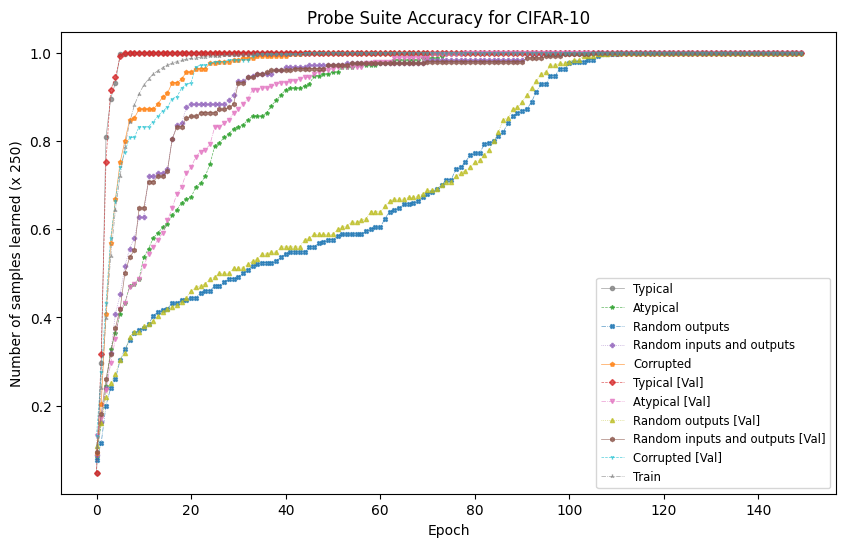

In [166]:
# Plot
plt.figure(figsize=(10, 6))
plt.title(f"Probe Suite Accuracy for {plot_titles['cifar10']}")
for i, suite in enumerate(suites):
    plt.plot(
        first_learned[suite],
        label=suite,
        alpha=0.75,
        linewidth=0.5,
        linestyle=line_styles[i % len(line_styles)],
        marker=marker_list[i % len(marker_list)],
        markersize=3,
        color=marker_colors[i % len(marker_colors)],
    )
plt.legend(loc="lower right", fontsize="small")
plt.xlabel("Epoch")
plt.ylabel("Number of samples learned (x 250)")


In [71]:
# compute cumulative number of samples learned pr epoch pr suite
consistently_learned = {
    "Typical": [],
    "Atypical": [],
    "Random outputs": [],
    "Random inputs and outputs": [],
    "Corrupted": [],
    "Typical [Val]": [],
    "Atypical [Val]": [],
    "Random outputs [Val]": [],
    "Random inputs and outputs [Val]": [],
    "Corrupted [Val]": [],
    "Train": [],
}

learned = {
    "Typical": set([]),
    "Atypical": set([]),
    "Random outputs": set([]),
    "Random inputs and outputs": set([]),
    "Corrupted": set([]),
    "Typical [Val]": set([]),
    "Atypical [Val]": set([]),
    "Random outputs [Val]": set([]),
    "Random inputs and outputs [Val]": set([]),
    "Corrupted [Val]": set([]),
    "Train": set([]),
}

suite_names = ["Typical", "Atypical", "Random outputs", "Random inputs and outputs", "Corrupted", "Typical [Val]", "Atypical [Val]", "Random outputs [Val]", "Random inputs and outputs [Val]", "Corrupted [Val]"]
temp_train = train_df[train_df['suite'] == 'Train']


learned['Train'] = set(temp_train.groupby(["epoch"]).get_group(max_epoch-1)['sample_index'].values[temp_train.groupby(["epoch"]).get_group(max_epoch-1)['prediction']])
for suite in suite_names:
    suite_group = val_df.groupby(["suite"]).get_group(suite)
    learned[suite] = set(suite_group.groupby(["epoch"]).get_group(max_epoch-1)['sample_index'].values[suite_group.groupby(["epoch"]).get_group(max_epoch-1)['prediction']])


In [72]:
suite_size = 250
train_size = 47500

for epoch in reversed(range(max_epoch)):
        epoch_train_group = temp_train.groupby(["epoch"]).get_group(epoch)
        epoch_train_group = epoch_train_group[epoch_train_group['sample_index'].isin(learned["Train"])]
        consistently_learned["Train"].insert(0, len(learned["Train"]) / train_size)
        learned["Train"] = set(
              epoch_train_group["sample_index"][epoch_train_group["prediction"]].values
            )
        epoch_val_group = val_df.groupby(["epoch"]).get_group(epoch)
        for suite in suite_names:
            suite_group = epoch_val_group.groupby(["suite"]).get_group(suite)
            suite_group = suite_group[suite_group['sample_index'].isin(learned[suite])]
            learned[suite] = set(
                suite_group["sample_index"][suite_group["prediction"]].values
            )
            consistently_learned[suite].insert(0, len(learned[suite]) / suite_size)

In [57]:
epoch_train_group = temp_train.groupby(["epoch"]).get_group(149)
epoch_train_group = epoch_train_group[epoch_train_group['sample_index'].isin(learned["Train"])]
epoch_train_group

,batch_idx,loss,sample_index,y,y_hat,epoch,stage,suite,prediction
2940256,0,0.000369,41580,9,9,149,train,Train,True
2940257,0,0.000074,9519,2,2,149,train,Train,True
2940258,0,0.000396,3226,2,2,149,train,Train,True
2940259,0,0.000484,23497,8,8,149,train,Train,True
2940261,0,0.001232,40118,1,1,149,train,Train,True
...,...,...,...,...,...,...,...,...,...
2990251,390,0.055328,27015,7,7,149,train,Train,True
2990252,390,0.000240,27058,9,9,149,train,Train,True
2990253,390,0.000132,13648,2,2,149,train,Train,True
2990254,390,0.000646,6999,7,7,149,train,Train,True


Text(0, 0.5, 'Percent Samples Learned (%)')

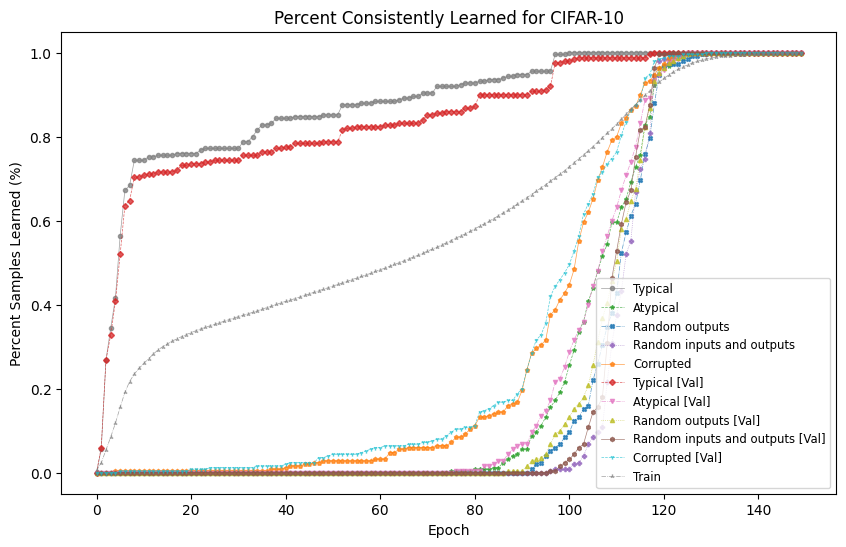

In [73]:
# Plot
suites = consistently_learned.keys()

plt.figure(figsize=(10, 6))
plt.title(f"Percent Consistently Learned for {plot_titles['cifar10']}")
for i, suite in enumerate(suites):
    plt.plot(
        consistently_learned[suite],
        label=suite,
        alpha=0.75,
        linewidth=0.5,
        linestyle=line_styles[i % len(line_styles)],
        marker=marker_list[i % len(marker_list)],
        markersize=3,
        color=marker_colors[i % len(marker_colors)],
    )
plt.legend(loc="lower right", fontsize="small")
plt.xlabel("Epoch")
plt.ylabel("Percent Samples Learned (%)")


In [74]:
len(suite_names)

10

In [50]:
# Plot
line_styles = ["solid", "dashed", "dashdot", "dotted"]
marker_list = ["o", "*", "X", "P", "p", "D", "v", "^", "h", "1", "2", "3", "4"]
marker_colors = [
    "tab:green",
    "tab:blue",
    "tab:purple",
    "tab:orange",
    "tab:red",
    "tab:pink",
    "tab:olive",
    "tab:brown",
    "tab:cyan",
    "tab:gray",
]

plot_titles = {
    "cifar10": "CIFAR-10",
    "cifar100": "CIFAR-100",
    "imagenet": "ImageNet",
}

/var/folders/zb/r3t36n8x4yxdbb4wy91dghwc0000gn/T/ipykernel_90552/1256528759.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df.sort_values(by=["epoch"], inplace=True)
/var/folders/zb/r3t36n8x4yxdbb4wy91dghwc0000gn/T/ipykernel_90552/1256528759.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df.loc[df["sample_index"].isin(val_indices), "suite"] = suite_name
/var/folders/zb/r3t36n8x4yxdbb4wy91dghwc0000gn/T/ipykernel_90552/1256528759.py:55: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, 

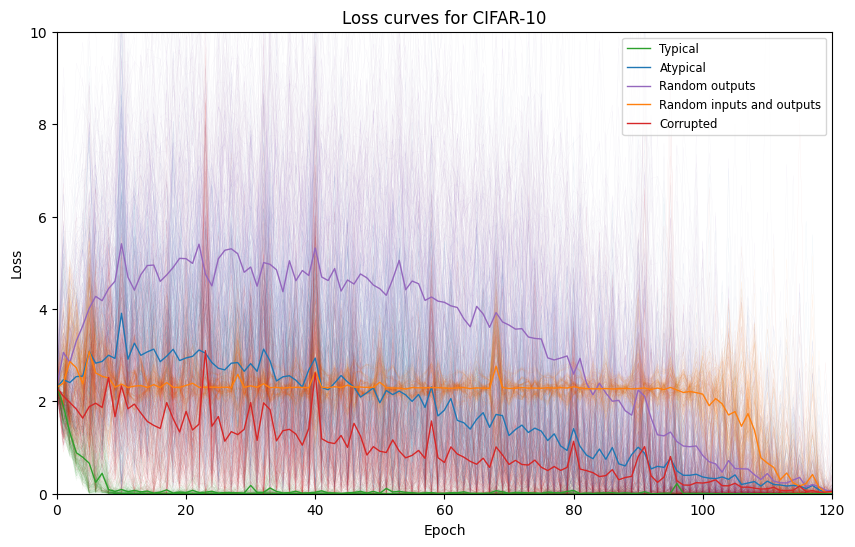

In [54]:
dataset_name = "cifar10"
loss_dataset_path = f"../models/losses/{dataset_name}-20230320_1038"
probe_suite = torch.load(f"../data/processed/{dataset_name}/train_probe_suite.pt")

df = get_loss_dataset(loss_dataset_path)

df.drop_duplicates(subset=["epoch", "sample_index", "stage"], inplace=True)

df["epoch"] = df["epoch"].astype(int)

max_epoch = df["epoch"].max() + 1
num_suite_samples = len(probe_suite.combined)
num_train_samples = len(probe_suite)

assert df["stage"][df["stage"] == "val"].count() == max_epoch * num_suite_samples
assert df["stage"][df["stage"] == "train"].count() == max_epoch * num_train_samples

val_df = df[df["stage"] == "val"]

suite_names = {
    "typical": "Typical",
    "atypical": "Atypical",
    "random_outputs": "Random outputs",
    "random_inputs_outputs": "Random inputs and outputs",
    "corrupted": "Corrupted",
}

# sort by epoch
val_df.sort_values(by=["epoch"], inplace=True)

plt.figure(figsize=(10, 6))
plt.title(f"Loss curves for {plot_titles[dataset_name]}")
i = 0

for suite_attr, suite_name in suite_names.items():
    suite = getattr(probe_suite, suite_attr)
    indices = get_indices_from_probe_suite(suite)
    random.shuffle(indices)
    #train_indices = indices[:250]
    val_indices = indices[250:]
    #val_df.loc[df["sample_index"].isin(train_indices), "suite"] = suite_name
    val_df.loc[df["sample_index"].isin(val_indices), "suite"] = suite_name
    for idx in val_indices:
        plt.plot(
              val_df["epoch"][val_df["sample_index"] == idx],
              val_df["loss"][val_df["sample_index"] == idx],
              alpha=0.15,
              linewidth=0.1,
              color=marker_colors[i],
              zorder=1,
        )
    
    # plot aggregated loss for each suite over all samples
    plt.plot(
        val_df.loc[val_df["suite"] == suite_name].groupby(["epoch"]).mean().index,
        val_df.loc[val_df["suite"] == suite_name].groupby(["epoch"]).mean()["loss"],
        label=suite_name,
        linewidth=1,
        color=marker_colors[i],
        zorder=2,
    )

    i += 1



# make legend such that each suite has a different color
#i = 0   
#for suite_attr, suite_name in suite_names.items():
#    plt.plot([], [], color=marker_colors[i], label=suite_name)
#    i += 1

plt.ylim(0, 10)
plt.xlim(0, 120)

plt.legend(loc="upper right", fontsize="small")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


In [27]:
val_df

,batch_idx,loss,sample_index,y,y_hat,epoch,stage,suite
50000,0,2.263672,772,1,4,0,val,Typical
51663,12,2.292969,31774,5,4,0,val,Random inputs and outputs
51664,13,2.511719,38376,0,4,0,val,Random inputs and outputs [Val]
51665,13,2.408203,14197,8,4,0,val,Random inputs and outputs [Val]
51666,13,2.240234,33767,6,4,0,val,Random inputs and outputs
...,...,...,...,...,...,...,...,...
2991091,6,0.000764,34335,7,7,149,val,Atypical [Val]
2991092,6,0.012558,30702,9,9,149,val,Atypical [Val]
2991093,6,0.000814,40800,5,5,149,val,Atypical
2991086,6,0.002003,33517,6,6,149,val,Atypical [Val]


In [24]:
# get indices from probe suite
atypical_indices = get_indices_from_probe_suite(probe_suite.atypical)

Text(0, 0.5, 'Loss')

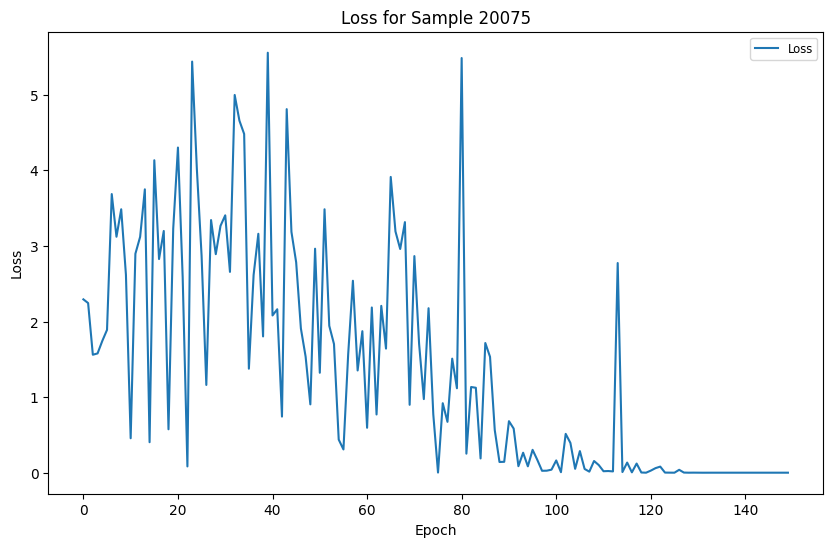

In [28]:
# plot the loss curve for one sample
sample_index = atypical_indices[0]
sample_df = val_df[val_df["sample_index"] == sample_index]
plt.figure(figsize=(10, 6))
plt.title(f"Loss for Sample {sample_index}")
plt.plot(sample_df["epoch"], sample_df["loss"], label="Loss")
plt.legend(loc="upper right", fontsize="small")
plt.xlabel("Epoch")
plt.ylabel("Loss")

In [14]:
temp.groupby(["sample_index"]).get_group()